In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use('seaborn-white')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=18)
plt.rc('font', family='sans-serif')
plt.rc('font', family='sans-serif')
%config InlineBackend.figure_format = 'retina'

In [2]:
def allelic_manifold(alpha, c, Nx, Ny, w):
    num = w**2+(alpha+1)*w
    denum = num+alpha
    x = num/denum + Nx
    num = (c*w)**2+(c*w)*(alpha+1)
    denum = num+alpha
    y = num/denum + Ny
    return np.log(x), np.log(y)

In [3]:
filename = './res_N5000_C4_W1000_fixed_noise.nc'
# Noise values
Nx = 0.0056
Ny = 0.000604

In [4]:
# Read the inference data
res_az = az.from_netcdf(filename)
# Training Data
x = res_az['observed_data']['x_like']
y = res_az['observed_data']['y_like']

In [5]:
# Summary statistics
summary_df = az.summary(res_az, hdi_prob=0.95, kind='stats')
summary_df

,mean,sd,hdi_2.5%,hdi_97.5%
log_alpha,8.794,0.880,7.122,10.000
log_c,-14.872,0.100,-15.000,-14.680
log_w[0],-8.048,2.303,-11.998,-4.394
log_w[1],-6.014,2.975,-11.398,-2.564
log_w[2],-3.852,2.267,-10.033,-2.333
...,...,...,...,...
w[18943],0.000,0.000,0.000,0.000
w[18944],0.000,0.000,0.000,0.000
w[18945],0.000,0.000,0.000,0.000
w[18946],0.088,0.010,0.069,0.108


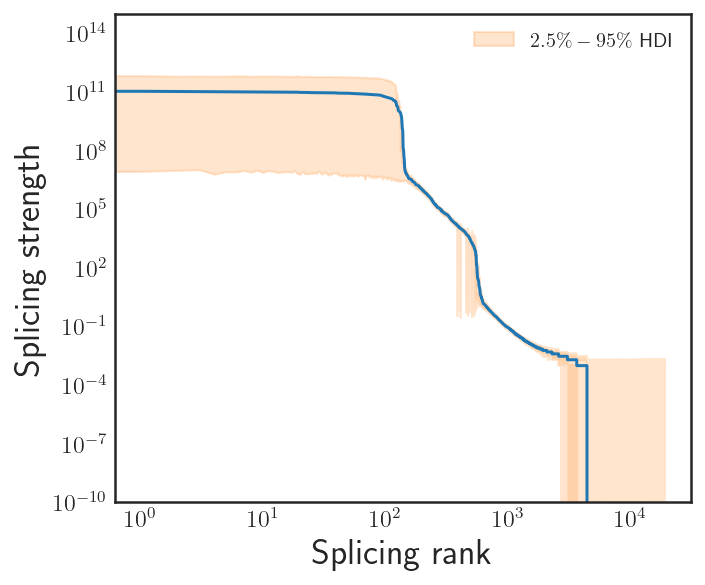

In [6]:
# Splicing strenght
w_infer = summary_df[summary_df.index.str.startswith('w')].copy()
w_infer.sort_values(by='mean', inplace=True, ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(5,5/1.2))
ss_idx = np.arange(len(w_infer))
ax.plot(ss_idx, w_infer['mean'].values)
ax.fill_between(ss_idx, w_infer['hdi_2.5%'], w_infer['hdi_97.5%'],
                color='C1', alpha=0.2, label=r'$2.5\%-95\%$ HDI')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Splicing rank')
ax.set_ylabel('Splicing strength')
ax.set_ylim([1e-10, 1e15])
ax.legend()
plt.tight_layout()
# plt.savefig('splicing_strength.pdf')

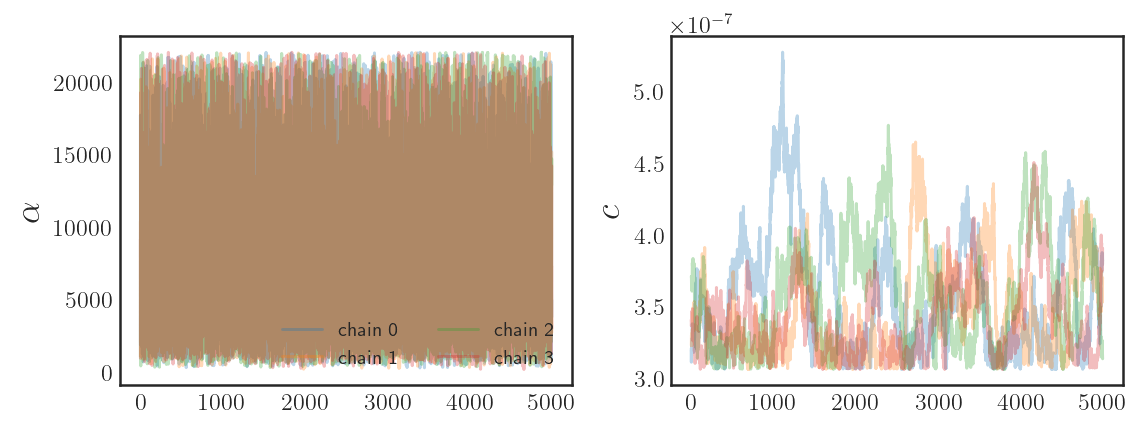

In [7]:
# Chain trace
fig, axs = plt.subplots(1, 2, figsize=(8,4/1.3))
for i in res_az.posterior['chain'].values:
    axs[0].plot(res_az['posterior']['alpha'][i,:], alpha=0.3, label=f'chain {i}')
    axs[1].plot(res_az['posterior']['c'][i,:], alpha=0.3)

axs[0].set_ylabel(r'$\alpha$')
axs[1].set_ylabel(r'$c$')
axs[0].legend(loc=4, ncol=2)
plt.tight_layout()
# plt.savefig('scalar_traces.pdf')

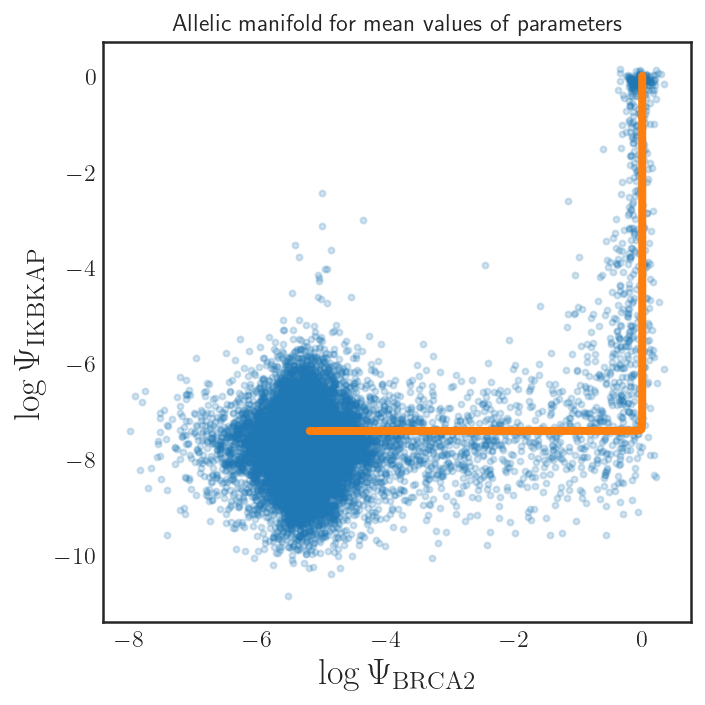

In [8]:
# Allelic Manifold
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x, y, '.', alpha=0.2, rasterized=True)
alpha_mean = np.exp(summary_df['mean']['log_alpha'])
c_mean = np.exp(summary_df['mean']['log_c'])
w_mean = np.sort(w_infer['mean'])
x_mean, y_mean = allelic_manifold(alpha_mean, c_mean, Nx, Ny, w_mean)
ax.plot(x_mean, y_mean, c='C1', linewidth=4)


ax.set_title('Allelic manifold for mean values of parameters')
ax.set_xlabel(r'$\log \Psi_{\rm{BRCA2}}$')
ax.set_ylabel(r'$\log \Psi_{\rm{IKBKAP}}$')
plt.tight_layout()
# plt.savefig('allelic_manifold.pdf')

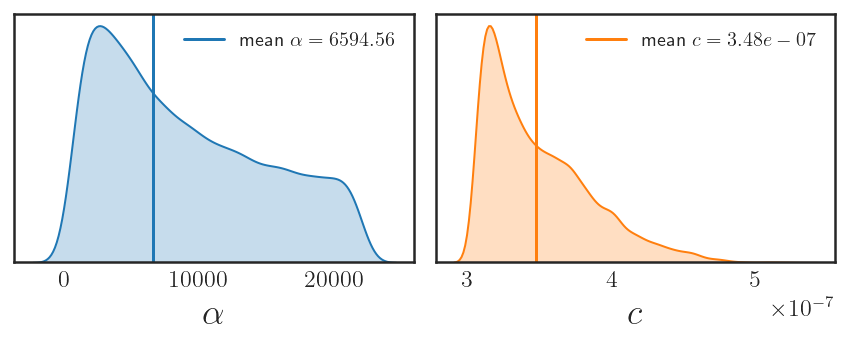

In [9]:
# Combine chains in posteriors
posteriors = res_az.posterior.stack(draws=("chain", "draw"))

# Density of the parameters
fig, axs = plt.subplots(1,2, figsize=(6,4/1.6))
sns.kdeplot(posteriors['alpha'], ax=axs[0], shade=True, color='C0')
sns.kdeplot(posteriors['c'], ax=axs[1], shade=True, color='C1')


axs[0].set_ylabel('')
axs[0].set_yticks([])
axs[0].set_xlabel(r'$\alpha$')
axs[0].axvline(x=alpha_mean, 
               label=r'mean $\alpha={:.2f}$'.format(alpha_mean))
axs[0].legend()


axs[1].set_ylabel('')
axs[1].set_yticks([])
axs[1].axvline(x=c_mean, c='C1',
               label=r'mean $c={:.2e}$'.format(c_mean))
axs[1].legend()
axs[1].set_xlabel(r'$c$')


plt.tight_layout()
# plt.savefig('scalars_dist.pdf')

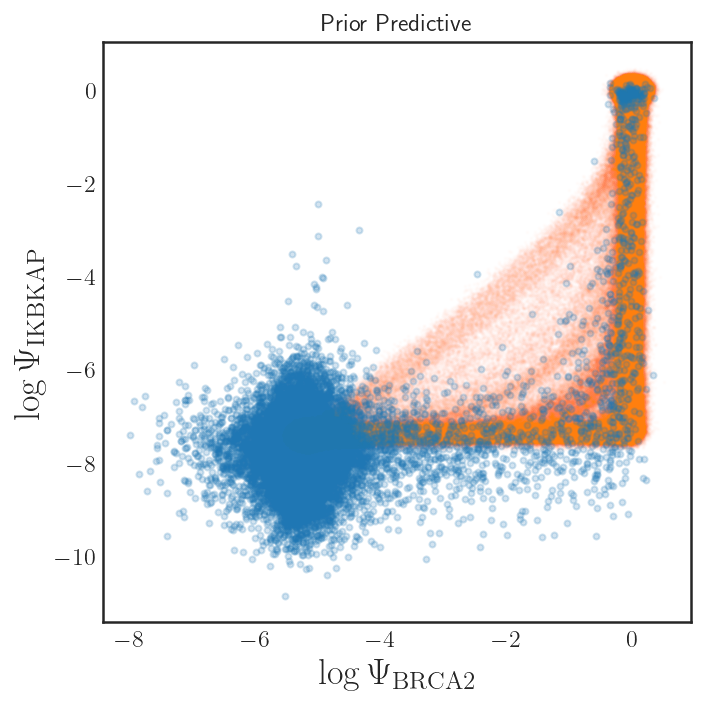

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x, y, '.', alpha=0.2, rasterized=True)
for x_l, y_l in zip(res_az['prior_predictive']['x_like'].values,
                    res_az['prior_predictive']['y_like'].values):
    ax.scatter(x_l, y_l, s=1, c='C1', alpha=0.01, rasterized=True)

ax.set_title('Prior Predictive')
ax.set_xlabel(r'$\log \Psi_{\rm{BRCA2}}$')
ax.set_ylabel(r'$\log \Psi_{\rm{IKBKAP}}$')
plt.tight_layout()
# plt.savefig('prior_predictive.pdf')